In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
from PIL import Image
import time
import matplotlib.pyplot as plt
import multiprocessing as mp
from multiprocessing import Pool, shared_memory, Array
from scipy.ndimage import gaussian_filter
from scipy.signal import convolve2d

paths:

In [ ]:
input_image_path = "/content/drive/MyDrive/ParallelProgramming/CA/input.jpg"
serial_output_image_path = "/content/drive/MyDrive/ParallelProgramming/CA/output/output_serial_image.jpg"
output_image_parallel_base_path = "/content/drive/MyDrive/ParallelProgramming/CA/output/output_parallel_image_{}p.jpg"

read image:

In [ ]:
input_image = Image.open(input_image_path).convert("L")
image_array = np.array(input_image)
padded_image = np.pad(image_array, ((1,1),(1,1)), mode='constant')

kernel:

In [ ]:
kernel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
kernel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

#kernel_x = np.array([[-3, 0, 3], [-10, 0, 10], [-3, 0, 3]])
#kernel_y = np.array([[-3, -10, -3], [0, 0, 0], [3, 10, 3]])

Serial Implementation

In [ ]:
def filter_serial(image,threshold_high,threshold_low):
    #blurred_image = gaussian_filter(image, sigma=1)
    height, width = image.shape
    grad_x = np.zeros_like(image, dtype=np.float32)
    grad_y = np.zeros_like(image, dtype=np.float32)
    for i in range(1, height - 1):
        for j in range(1, width - 1):
            grad_x[i, j] = np.sum(image[i-1:i+2, j-1:j+2] * kernel_x)
            grad_y[i, j] = np.sum(image[i-1:i+2, j-1:j+2] * kernel_y)

    """
    image = image.astype(np.float32)
    grad_x = convolve2d(image, kernel_x, mode='valid')
    grad_y = convolve2d(image, kernel_y, mode='valid')"""

    grad = np.sqrt(grad_x**2 + grad_y**2)
    grad = (grad / grad.max()) * 255
    # apply thresholding
    edge_detected_image = np.zeros_like(grad, dtype=np.uint8)
    mask_strong = grad > threshold_high
    mask_weak = (grad > threshold_low) & (grad <= threshold_high)
    edge_detected_image[mask_strong] = 255
    edge_detected_image[mask_weak] = ((grad[mask_weak] - threshold_low) / (threshold_high - threshold_low) * 255).astype(np.uint8)

    return Image.fromarray(edge_detected_image)


In [ ]:
start_time_serial = time.time()
result_serial = filter_serial(image_array,90,10)
end_time_serial = time.time()
serial_time = end_time_serial - start_time_serial
print(f"Serial Execution Time: {serial_time:.4f} seconds")

Serial Execution Time: 4.2554 seconds


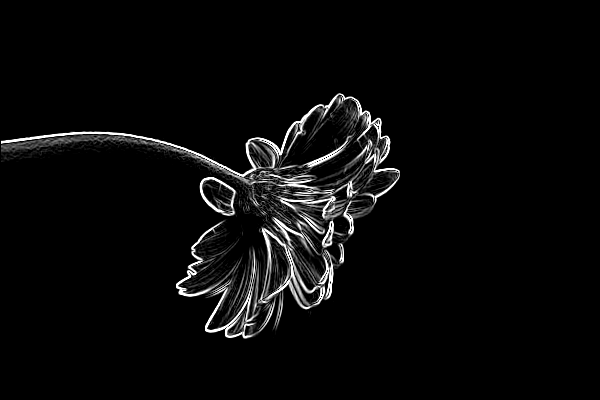

In [ ]:
result_serial.save(serial_output_image_path)
display(result_serial)

Parallel Implementation

In [ ]:
def process_chunk(chunk_data):
    chunk, kernel_x, kernel_y = chunk_data
    chunk_height, chunk_width = chunk.shape
    grad_x = np.zeros((chunk_height - 2, chunk_width - 2), dtype=np.float32)
    grad_y = np.zeros_like(grad_x, dtype=np.float32)

    for i in range(1, chunk_height - 1):
        for j in range(1, chunk_width - 1):
            patch = chunk[i-1:i+2, j-1:j+2]
            grad_x[i-1, j-1] = np.sum(patch * kernel_x)
            grad_y[i-1, j-1] = np.sum(patch * kernel_y)

    grad = np.sqrt(grad_x**2 + grad_y**2)
    return grad

def filter_parallel(image, threshold_high, threshold_low, num_processes):
    #padded_image = np.pad(image, ((1,1),(1,1)), mode='constant')
    height, width = image.shape

    chunk_size = height // num_processes
    chunks = []
    for i in range(num_processes):
        start = i * chunk_size
        end = start + chunk_size + 2
        if i == num_processes - 1:
            end = height + 2
        chunk = image[start:end, :]
        chunks.append((chunk, kernel_x, kernel_y))

    with mp.Pool(processes=num_processes) as pool:
        results = pool.map(process_chunk, chunks)

    grad_image = np.vstack(results)
    global_max = np.max(grad_image)
    grad_normalized = (grad_image / global_max) * 255
    edge_detected_image = np.zeros_like(grad_image, dtype=np.uint8)
    mask_strong = grad_normalized > threshold_high
    mask_weak = (grad_normalized > threshold_low) & (grad_normalized <= threshold_high)
    edge_detected_image[mask_strong] = 255
    edge_detected_image[mask_weak] = ((grad_normalized[mask_weak] - threshold_low) / (threshold_high - threshold_low) * 255).astype(np.uint8)

    return Image.fromarray(edge_detected_image)

Execution time with 1 processes: 3.5228 seconds
Execution time with 2 processes: 3.9014 seconds
Execution time with 3 processes: 6.6499 seconds
Execution time with 4 processes: 3.7280 seconds
Execution time with 5 processes: 4.1029 seconds
Execution time with 8 processes: 5.1215 seconds
Execution time with 10 processes: 6.2236 seconds
Execution time with 16 processes: 3.8302 seconds


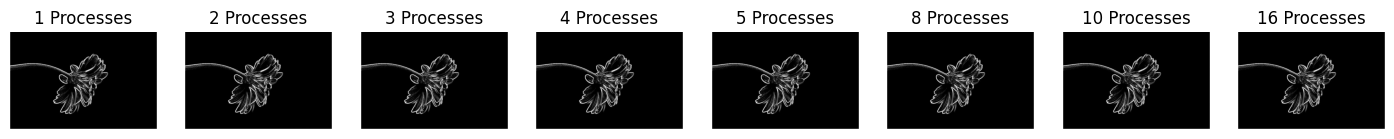

In [ ]:
processor_counts = [1, 2, 3, 4, 5, 8, 10, 16]
threshold_high = 90
threshold_low = 10
execution_times = {}
output_images = {}

for num_processes in processor_counts:
    start_time = time.time()
    result_image = filter_parallel(padded_image, threshold_high, threshold_low, num_processes)
    end_time = time.time()
    execution_times[num_processes] = end_time - start_time
    output_images[num_processes] = result_image
    result_image.save(output_image_parallel_base_path.format(num_processes))
    print(f"Execution time with {num_processes} processes: {execution_times[num_processes]:.4f} seconds")

plt.figure(figsize=(20, 10))

for idx, p in enumerate(processor_counts, start=2):
    img_path = output_image_parallel_base_path.format(p)
    parallel_image = Image.open(img_path)
    plt.subplot(1, len(processor_counts)+1, idx)
    plt.imshow(parallel_image, cmap='gray')
    plt.title(f'{p} Processes')
    plt.axis('off')

plt.show()

Analysis


Speedup and Efficiency:
1 processes: Speedup = 1.21, Efficiency = 1.21
2 processes: Speedup = 1.09, Efficiency = 0.55
3 processes: Speedup = 0.64, Efficiency = 0.21
4 processes: Speedup = 1.14, Efficiency = 0.29
5 processes: Speedup = 1.04, Efficiency = 0.21
8 processes: Speedup = 0.83, Efficiency = 0.10
10 processes: Speedup = 0.68, Efficiency = 0.07
16 processes: Speedup = 1.11, Efficiency = 0.07


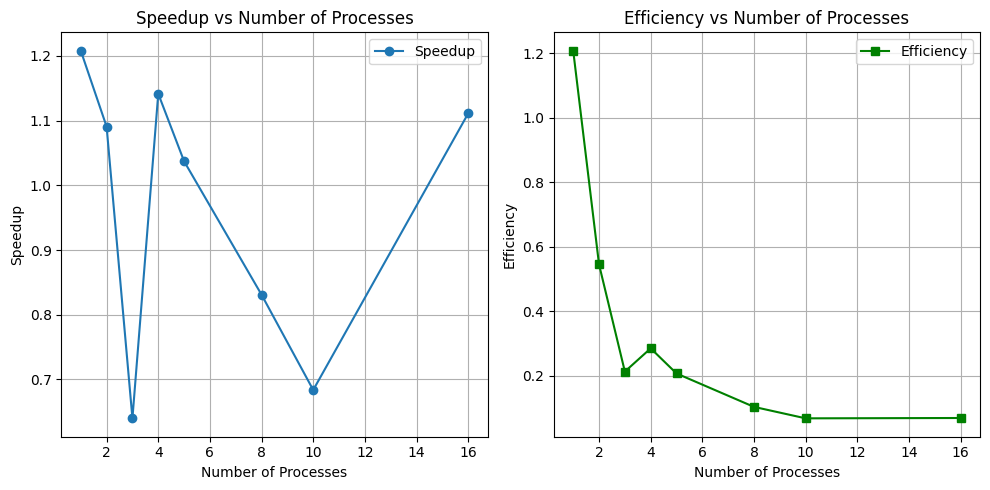

In [ ]:
speedups = {p: serial_time / execution_times[p] for p in processor_counts}
efficiencies = {p: (speedups[p] / p) for p in processor_counts}

print("\nSpeedup and Efficiency:")
for p in processor_counts:
    print(f"{p} processes: Speedup = {speedups[p]:.2f}, Efficiency = {efficiencies[p]:.2f}")

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(processor_counts, [speedups[p] for p in processor_counts], marker='o', label='Speedup')
ax[0].set_title('Speedup vs Number of Processes')
ax[0].set_xlabel('Number of Processes')
ax[0].set_ylabel('Speedup')
ax[0].legend()
ax[0].grid(True)

ax[1].plot(processor_counts, [efficiencies[p] for p in processor_counts], marker='s', color='g', label='Efficiency')
ax[1].set_title('Efficiency vs Number of Processes')
ax[1].set_xlabel('Number of Processes')
ax[1].set_ylabel('Efficiency')
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()
